# Particle Identification using GNN on HGCAL dataset- Noise+ Later profile+ Layer Energy Profile

Earlier, we had done the normalization per hit per layer. This had completely removed the longitudinal profile information. We only had the lateral profile- per layer relative energy at each hit cell, with respect to the hit cell with maximum energy deposit in that particular layer
Here, we shall add this longitudinal profile information manually using the layer profile, which is the normalized tensor, representing the per event relative total energy in each layer, with respect to the layer with maximum total hit energy.
Now, we will develop a more **advanced model**.

## Importing the required packages

In [1]:
#General packages
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt

#Torch packages
import torch
import torch.nn as nn
import torch.nn.functional as F

#Packages for GNN
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
#from torch_geometric.nn import GCNConv, global_add_pool
from sklearn.neighbors import NearestNeighbors

## ROOT ---> Numpy arrays

In [2]:
#file=uproot.open("ntuple_pi+_100GeV_100keve.root:AllLayers")
#branches=["hit_x","hit_y","hit_z","hit_l","hit_E"]
#events=file.arrays(branches,library="ak")

In [3]:
#events  ### Awkawrd array in Dictionary like format
#type(events)
#events.hit_x # Returns the awkard arrays for the hit_x for all events

In [4]:
#events[0].hit_x # Returns the hit_x data for the first event, as numpy arrays

## Preparing the Dataset

In [5]:
#Defining the root files and their path names
particle_files={
    "pi+":"ntuple_pi+_100GeV_100keve.root:AllLayers",
    "e+":"ntuple_e+_100_GeV_100Keve.root:AllLayers",
    "Y":"ntuple_gamma_100GeV_25keve_p1.root:AllLayers",
    "K-":"ntuple_kaon-_100GeV_20keve_p1.root:AllLayers",
    "K+":"ntuple_kaon+_100GeV_20keve_p1.root:AllLayers",
    "K_0":"ntuple_kaon0L_100GeV_10keve_test.root:AllLayers",
    "mu+":"ntuple_mu+_100GeV_100keve.root:AllLayers",
    "n":"ntuple_neutron_100GeV_10keve_test.root:AllLayers",
    "p":"ntuple_proton_100GeV_20keve_p1.root:AllLayers"
}
particle_ids={
    "pi+":0,
    "e+":1,
    "Y":2,
    "K-":3,
    "K+":4,
    "K_0":5,
    "mu+":6,
    "n":7,
    "p":8
}


In [6]:
#Defining the root files and their path names
particle_files={
    "pi+":"ntuple_pi+_100GeV_100keve.root:AllLayers",
    "e+":"ntuple_e+_100_GeV_100Keve.root:AllLayers",
    "Y":"ntuple_gamma_100GeV_25keve_p1.root:AllLayers",
    
}
particle_ids={
    "pi+":0,
    "e+":1,
    "Y":2
}


In [7]:
branches=["hit_x","hit_y","hit_z","hit_l","hit_E"]
all_events=[]
all_labels=[]

for pname,file_path in particle_files.items():
    file=uproot.open(file_path)
    events=file.arrays(branches,library="ak")[:1000] #Only 1000 events for now
    #Assigning particle ids
    pid=particle_ids[pname]
    #Store everything as a tuple
    all_events.extend([(events[i],pid) for i in range(len(events))])

In [8]:
#Shuffling
from sklearn.utils import shuffle
all_events=shuffle(all_events,random_state=28)

In [9]:
all_events[0][0]

<Record {hit_x: [0, ...], hit_y: [...], ...} type='{hit_x: var * float64, h...'>

In [10]:
all_events[0][1]

2

In [11]:
all_events[4][1]

0

In [12]:
np.sum(all_events[0][0].hit_E)

0.8654343613016175

In [13]:
np.sum(all_events[0][0].hit_E)

0.8654343613016175

### Adding Noise

In [14]:
def add_noise(event,noise_mean,noise_std):
    #List to store noisy hits for this event
    #noisy_hits=[]
    #Conversion of hits to numy array for manipulation
    #hits=ak.to_list(event.hit_E)
    E_signal=np.array(event.hit_E)
    #Generate the Gaussian noise
    noise=np.random.normal(loc=noise_mean,scale=noise_std,size=np.size(E_signal))
    #Adding noise
    E_noisy=E_signal+noise
    #Clipping the zero and negative energy noise
    E_noisy[E_noisy<=0]=0.0
    #Convert to awkward array
    #E_noisy_ak=ak.Array(E_noisy)
    #Rebuilding the record manually
    event_noisy=ak.Record(
    {
        "hit_x":event.hit_x,
        "hit_y":event.hit_y,
        "hit_z":event.hit_z,
        "hit_l":event.hit_l,
        "hit_E":E_noisy
    })
    
    return event_noisy

In [15]:
np.random.seed(42) #For explaining reproductivity
all_events_noisy=[]
noise_mean=0.0
noise_std=0.03

for event,pid in all_events:
    event_noisy=add_noise(event,noise_mean=noise_mean,noise_std=noise_std)
    all_events_noisy.append((event_noisy,pid))

In [16]:
all_events_noisy[0][0]

<Record {hit_x: [0, ...], hit_y: [...], ...} type='{hit_x: 697 * float64, h...'>

In [17]:
#np.sum(all_events_noisy[0][0].hit_E)

## Longitudinal profile- Layer Energy Profile

In [18]:
def layer_profile(event,global_max_layers=50):
    layers=ak.to_numpy(event.hit_l)
    layers=torch.tensor(layers)
    energies=ak.to_numpy(event.hit_E)
    energies=torch.tensor(energies)
    layer_sums=torch.bincount(input=layers-1,weights=energies,minlength=global_max_layers)
    #Maximum energy
    max_energy=layer_sums.max()
    if max_energy>0:
        layer_sums_norm=layer_sums/max_energy
    #return torch.tensor(layer_sums_norm,dtype=torch.float64)
    layer_sums_norm=torch.unsqueeze(layer_sums_norm,0)
    return layer_sums_norm

In [19]:
#Test
layer_profile(all_events_noisy[4][0]).shape

torch.Size([1, 50])

In [20]:
#layer_profile(all_events_noisy[5][0])

In [21]:
#A=torch.tensor([1,2,3])
#B=torch.unsqueeze(A,0)
#B.shape
#A.unsqueeze(0)
#print(A.shape)

## Lateral Profile- Average energy per hits per layer

In [22]:
def normalize_hits_by_layer(event):
    layer=ak.to_numpy(event.hit_l)
    energy=ak.to_numpy(event.hit_E)
    #Prepare an array to store normalized energies
    energy_norm=np.zeros_like(energy)
    #Finding unique layers
    unique_layer=np.unique(layer)
    for l in unique_layer:
        #Extract the inndices of the hits in this layer
        mask=layer==l
        if np.any(mask):
            max_energy=energy[mask].max()
            if max_energy>0:
                energy_norm[mask]=energy[mask]/max_energy
            elif max_energy==0:
                energy_norm[mask]=0.0
    #Rebuild the record
    event_norm=ak.Record({
        "hit_x":event.hit_x,
        "hit_y":event.hit_y,
        "hit_z":event.hit_z,
        "hit_l":event.hit_l,
        "hit_E":energy_norm
    })
    return event_norm

In [23]:
all_events_normalized=[]
for event,pid in all_events_noisy:
    event_norm=normalize_hits_by_layer(event)
    all_events_normalized.append((event_norm,pid))

## Creating the event graphs

In [24]:
def create_graph(event,k=8):
    x=ak.to_numpy(event.hit_x)
    y=ak.to_numpy(event.hit_y)
    z=ak.to_numpy(event.hit_z)
    l=ak.to_numpy(event.hit_l)
    E=ak.to_numpy(event.hit_E)
    #Removing zero energy hits
    mask_E=E>0
    x,y,z,l,E=x[mask_E],y[mask_E],z[mask_E],l[mask_E],E[mask_E]
    coords=np.column_stack((x,y,z))
    N=len(coords)
    if N<k+1:
        return None
    
    #Node features
    node_features=torch.from_numpy(np.column_stack((x,y,z,l,E))).float()

    #Global KNN
    knn=NearestNeighbors(n_neighbors=k+1,algorithm="kd_tree").fit(coords)
    knn_dist,knn_idx=knn.kneighbors(coords)
    knn_idx=knn_idx[:,1:] #Removes the self hit
    #print(knn_dist[9,:],knn_idx[9,:])

    #Edge construction
    src=np.repeat(np.arange(N),k)
    dst=knn_idx.reshape(-1)
    mask=dst>=0
    src,dst=src[mask],dst[mask]
    edge_index=torch.tensor(np.vstack([src,dst]),dtype=torch.long)

    #Edge attributes
    edge_attr = torch.tensor((E[src] * E[dst]).reshape(-1, 1),dtype=torch.float)

    #Final creation
    graph= Data(x=node_features,edge_index=edge_index,edge_attr=edge_attr)
    return graph

In [25]:
#graph=[create_graph(event,k=8) for event in events]    

In [26]:
#creating graphs for all events
graph=[]
for event,pid in all_events_noisy:
    g=create_graph(event,k=8)
    profile=layer_profile(event,global_max_layers=50)
    if g is not None:
        g.y=torch.tensor([pid],dtype=torch.long)
        g.layer_profile=profile
        graph.append(g)

In [27]:
graph[0]

Data(x=[358, 5], edge_index=[2, 2864], edge_attr=[2864, 1], y=[1], layer_profile=[1, 50])

In [28]:
#Debugging-1
#for g in graph[:20]:
#    print(g.y.item())

In [29]:
#Debugging-2
#g = graph[3]
#print(g.y)
#print(g.y.shape)


In [30]:
#Test-1
graph[:20]

[Data(x=[358, 5], edge_index=[2, 2864], edge_attr=[2864, 1], y=[1], layer_profile=[1, 50]),
 Data(x=[378, 5], edge_index=[2, 3024], edge_attr=[3024, 1], y=[1], layer_profile=[1, 50]),
 Data(x=[372, 5], edge_index=[2, 2976], edge_attr=[2976, 1], y=[1], layer_profile=[1, 50]),
 Data(x=[358, 5], edge_index=[2, 2864], edge_attr=[2864, 1], y=[1], layer_profile=[1, 50]),
 Data(x=[371, 5], edge_index=[2, 2968], edge_attr=[2968, 1], y=[1], layer_profile=[1, 50]),
 Data(x=[240, 5], edge_index=[2, 1920], edge_attr=[1920, 1], y=[1], layer_profile=[1, 50]),
 Data(x=[343, 5], edge_index=[2, 2744], edge_attr=[2744, 1], y=[1], layer_profile=[1, 50]),
 Data(x=[346, 5], edge_index=[2, 2768], edge_attr=[2768, 1], y=[1], layer_profile=[1, 50]),
 Data(x=[338, 5], edge_index=[2, 2704], edge_attr=[2704, 1], y=[1], layer_profile=[1, 50]),
 Data(x=[287, 5], edge_index=[2, 2296], edge_attr=[2296, 1], y=[1], layer_profile=[1, 50]),
 Data(x=[149, 5], edge_index=[2, 1192], edge_attr=[1192, 1], y=[1], layer_profil

In [31]:
#Test-2
graph[2].layer_profile

tensor([[0.0906, 0.0480, 0.1704, 0.3410, 0.1558, 0.6987, 0.6005, 0.6713, 0.4625,
         0.5305, 1.0000, 0.6171, 0.6499, 0.6462, 0.4432, 0.6363, 0.4901, 0.4048,
         0.5732, 0.3091, 0.1794, 0.3651, 0.1093, 0.1825, 0.0282, 0.0626, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000]], dtype=torch.float64)

## Splitting into training and testing

In [32]:
from sklearn.model_selection import train_test_split

#First split: Train vs Temp(Val+Test)
train_data, temp_data= train_test_split(graph, test_size=0.3, random_state=42)

#Second split: Test vs Val
val_data, test_data= train_test_split(temp_data, test_size=0.7, random_state=42)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Test samples: {len(test_data)}")

Training samples: 2100
Validation samples: 270
Test samples: 630


In [33]:
#graph[:64]

## Using DataLoader

In [34]:
from torch_geometric.loader import DataLoader
batch_size=64

train_loader=DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader=DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader=DataLoader(test_data, batch_size=batch_size, shuffle=True)

## Computing layer profile for events in each batch

In [35]:
#Computing the layer_profile per graph
#def 

In [36]:
def layer_profile_batchwise(batch,global_max_layers=50):
    profiles=[]
    for graph in batch.to_data_list():
        profile=layer_profile(graph,global_max_layers=global_max_layers)
        profiles.append(profile)
    profiles=torch.stack(profiles,dim=1)
    return profiles.float()

## Making the GCN

### Developing the Message Passing Block

In [37]:
#Making the message passing network
import torch
from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
class GCNConv(MessagePassing):
    def __init__(self,in_channels,out_channels):
        #Here, in_channels: Input node features
        super().__init__(aggr='add')
        self.lin=Linear(in_channels,out_channels,bias=False)
        self.bias = Parameter(torch.Tensor(out_channels))
        self.reset_parameters()
        
    def reset_parameters(self):
        self.lin.reset_parameters()
        self.bias.data.zero_()
        
    def forward(self,x,edge_index):
        # x has the shape [No. of hits, in_channels]
        #edge_index has shape [2, No. of edges]
        #Step-1: Add self loops
        edge_index,_=add_self_loops(edge_index,num_nodes=x.size(0))
        #Step-2: Linearly transform node feature matrix
        x=self.lin(x)
        #Step-3: Compute Normalization
        row,col=edge_index
        deg=degree(col,x.size(0))
        deg_inv_sqr=deg.pow(-0.5)
        deg_inv_sqr[deg_inv_sqr==float('inf')]=0
        norm=deg_inv_sqr[row]*deg_inv_sqr[col]
        #Step-4-5: Propagating the message- Normalize the node features and then add
        out=self.propagate(edge_index,x=x,norm=norm)
        #Step 6: Apply the end bias vector
        out=out+self.bias
        
        return out
    
    def message(self, x_j, norm):
        return norm.view(-1,1)*x_j

### Stacking the GNN layers for 'Convolution'

#### Advanced Model

In [52]:
import torch
from torch import nn
import torch.nn.functional as F
#from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_add_pool,BatchNorm

class GCN_Event_Classifier(nn.Module):
    def __init__(self, input_dim,hidden_dim,output_dim):
        super().__init__()
        #The GCN Layers
        ## First-layer
        self.conv1=GCNConv(input_dim,hidden_dim)
        self.bn1=BatchNorm(hidden_dim)
        ## 6 repeated blocks
        self.convs=nn.ModuleList()
        self.bns=nn.ModuleList()
        for i in range(6):
            self.convs.append(GCNConv(hidden_dim,hidden_dim))
            self.bns.append(BatchNorm(hidden_dim))
        ##Final layer
        self.final_conv=GCNConv(hidden_dim,hidden_dim)
        #Regularization
        self.dropout=nn.Dropout(p=0.1)
        
        #Output- MLP- mainly doing the classification task.
        self.output=nn.Sequential(
            nn.Linear(hidden_dim+50,hidden_dim),
            #nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,hidden_dim),
            #nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,output_dim)
        )
        
    def forward(self,data):
        #x,edge_index=data.x, data.edge_index
        x,edge_index,batch=data.x,data.edge_index,data.batch
        #print(data.x.shape)
        
        #-----------Graph Convolution--------------
        #####First GCN Block#######
        x=self.conv1(x,edge_index)
        x=self.bn1(x)
        x=F.relu(x)
        x=self.dropout(x)
        #### Repeated convolutions ####
        for conv,bn in zip(self.convs,self.bns):
            x=conv(x,edge_index)
            x=bn(x)
            x=F.relu(x)
            x=self.dropout(x)
        #### Final convolution ####
        x=self.final_conv(x,edge_index)
        #Saving the node embeddings
        node_embedding=x
        #print(node_embedding.shape)
        
        #Graph-level event embedding
        event_embedding=global_add_pool(x,batch) # shape: [batch_size,hidden_dim]
        #print(event_embedding.shape)
        
        #Get layer profile
        layer_profile=data.layer_profile
        #print(layer_profile.shape)
        #if layer_profile.dim()==1:
        #    layer_profile=layer_profile.unsqueeze(0)
        layer_profile=layer_profile.float()
        #layer_profile.unsqueeze(0)
        #if layer_profile.size(0)!=event_embedding.size(0):
        #    layer_profile=layer_profile.expand(event_embedding.size(0),-1)
            
        
        #layer_profile=data.layer_profile.float()
        #Combined- Concatenate the features
        combined=torch.cat([event_embedding,layer_profile],dim=1)
        #print(combined.shape)
        #Node-level-predictions
        out=self.output(combined)
        
        return out,node_embedding

In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [54]:
device

device(type='cuda')

In [55]:
#model=GCN_Event_Classifier(input_dim=5,hidden_dim=64,output_dim=9).to(device)
layer_dim=graph[0].layer_profile.shape[0]
model=GCN_Event_Classifier(input_dim=5,hidden_dim=25,output_dim=3).to(device)

In [56]:
model

GCN_Event_Classifier(
  (conv1): GCNConv()
  (bn1): BatchNorm(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convs): ModuleList(
    (0-5): 6 x GCNConv()
  )
  (bns): ModuleList(
    (0-5): 6 x BatchNorm(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (final_conv): GCNConv()
  (dropout): Dropout(p=0.1, inplace=False)
  (output): Sequential(
    (0): Linear(in_features=75, out_features=25, bias=True)
    (1): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=25, out_features=25, bias=True)
    (4): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=25, out_features=3, bias=True)
  )
)

### Developing the training, validation and testing loops

In [57]:
optimizer=torch.optim.Adam(model.parameters(),lr=0.0001)
criterion=torch.nn.CrossEntropyLoss()

In [58]:
#Training loop
def train():
    model.train()
    total_loss=0.0
    for batch in train_loader:
        batch=batch.to(device)
        optimizer.zero_grad()
        #Computing batchwise layer profiles
        #profiles=layer_profile_batchwise(batch,global_max_layers=50)
        out,_=model(batch)
        loss=criterion(out,batch.y)
        #Backpropagation
        loss.backward() 
        optimizer.step()
        total_loss+=loss.item()
        
    return total_loss/len(train_loader)


In [59]:
#Validation loop
def validate():
    model.eval()
    total_loss=0.0
    with torch.no_grad():
        for batch in val_loader:
            batch=batch.to(device)
            out,_=model(batch)
            loss=criterion(out,batch.y)
            total_loss+=loss.item()
    return total_loss/len(val_loader)

In [60]:
#Running the model
#epochs=100
epochs=20
train_losses=[]
val_losses=[]
for epochs in range(1,epochs+1):
    train_loss=train()
    val_loss=validate()
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epochs}, Train Loss: {train_loss:.4f}, Val loss: {val_loss:.4f}")

Epoch 1, Train Loss: 1.0339, Val loss: 1.0296
Epoch 2, Train Loss: 0.9111, Val loss: 0.8288
Epoch 3, Train Loss: 0.8503, Val loss: 0.8095
Epoch 4, Train Loss: 0.8037, Val loss: 0.7309
Epoch 5, Train Loss: 0.7552, Val loss: 0.7000
Epoch 6, Train Loss: 0.7292, Val loss: 0.6798
Epoch 7, Train Loss: 0.7033, Val loss: 0.6816
Epoch 8, Train Loss: 0.6745, Val loss: 0.6478
Epoch 9, Train Loss: 0.6704, Val loss: 0.6111
Epoch 10, Train Loss: 0.6500, Val loss: 0.6323
Epoch 11, Train Loss: 0.6379, Val loss: 0.6259
Epoch 12, Train Loss: 0.6185, Val loss: 0.5985
Epoch 13, Train Loss: 0.6160, Val loss: 0.6024
Epoch 14, Train Loss: 0.6055, Val loss: 0.5837
Epoch 15, Train Loss: 0.5949, Val loss: 0.5600
Epoch 16, Train Loss: 0.5860, Val loss: 0.5492
Epoch 17, Train Loss: 0.5799, Val loss: 0.5526
Epoch 18, Train Loss: 0.5765, Val loss: 0.5265
Epoch 19, Train Loss: 0.5700, Val loss: 0.5495
Epoch 20, Train Loss: 0.5654, Val loss: 0.5042


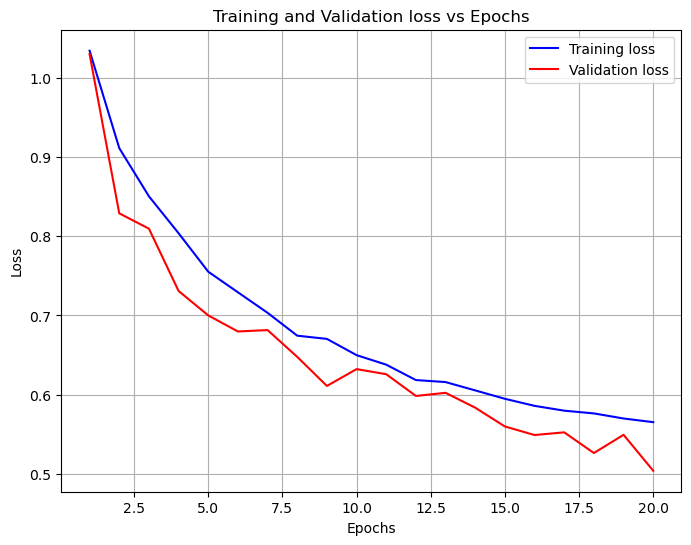

In [61]:
#Visualizing the model performance
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.plot(range(1,len(train_losses)+1),train_losses,label="Training loss",color="Blue")
plt.plot(range(1,len(val_losses)+1),val_losses,label="Validation loss",color="Red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation loss vs Epochs")
plt.legend()
plt.grid()
plt.show()

In [62]:
# Testing the model
model.eval()
predictions=[]
true_labels=[]
probablities=[]

with torch.no_grad():
    for batch in test_loader:
        batch=batch.to(device)
        out,_=model(batch)
        preds=torch.argmax(out,dim=1)  #Predictions
        probs=torch.softmax(out,dim=1) #Probablities
        
        predictions.append(preds.cpu())
        true_labels.append(batch.y.cpu())
        probablities.append(probs.cpu())
    
predictions=torch.cat(predictions)
true_labels=torch.cat(true_labels)
probablities=torch.cat(probablities)

### Visualizing the performance of the model

#### Confusion matrix

In [63]:
# Confusion matrix
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

cm=confusion_matrix(true_labels,predictions,normalize='true')


In [64]:
pid = {v: k for k, v in particle_ids.items()}
class_names=[pid[i] for i in range(len(pid))]

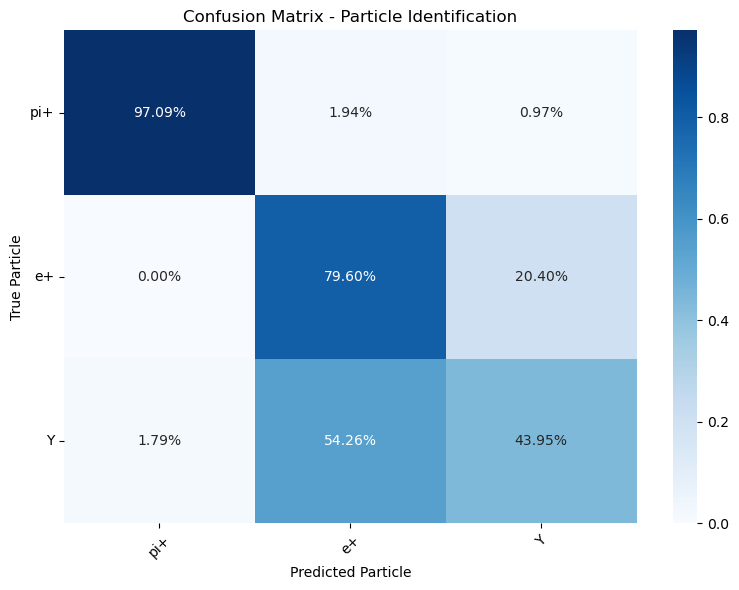

In [65]:
plt.figure(figsize=(8,6))

sns.heatmap(cm,
            annot=True,
            fmt='.2%',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel("Predicted Particle")
plt.ylabel("True Particle")
plt.title("Confusion Matrix - Particle Identification")

plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()


#### ROC curve

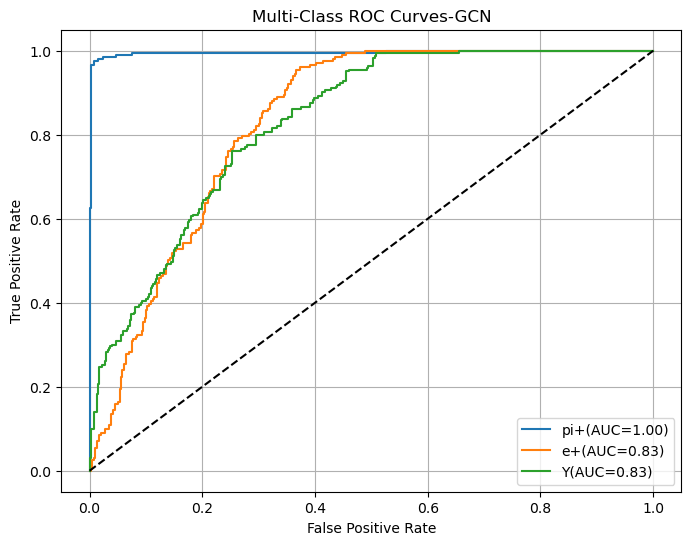

In [66]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve,auc

#Here, we need to convert the labels to one-hot levels for ROC only
num_classes=3
y_true_bin=label_binarize(true_labels.numpy(),classes=range(num_classes))
y_score=probablities.numpy()

plt.figure(figsize=(8,6))

for i in range(num_classes):
    fpr, tpr,_=roc_curve(y_true_bin[:,i],y_score[:,i])
    roc_auc=auc(fpr,tpr)
    plt.plot(fpr,tpr,label=f'{class_names[i]}(AUC={roc_auc:.2f})')
plt.grid()
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curves-GCN")
plt.legend()
plt.show()

#### Histograms